In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from itertools import combinations
from collections import Counter
from zipfile import ZipFile
import os
from networkx.algorithms.community import girvan_newman
import json
import requests
import re
import matplotlib.patches as mpatches
import itertools
import matplotlib.cm as cm
from pprint import pprint
import math
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from tqdm import tqdm
import gensim
from gensim import corpora
from wordcloud import WordCloud

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
pd.options.mode.chained_assignment = None  # default='warn'

/opt/anaconda3/lib/python3.9/site-packages/botocore/httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext
/opt/anaconda3/lib/python3.9/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
[nltk_data] Downloading package wordnet to /Users/ellen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ellen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Reusable variables
seed = 33
d_color = "#4152ec"
colors = ['#292929', '#768695', d_color, '#50dcff', '#ffa30e', '#ffe72f', '#f43131', '#ff9ad2', '#2ca02c', '#a8ee72', '#795133', '#c98d66']

In [3]:
# used csv files, linking it with their source zip files
csv_to_zip_source = {
    "Netflix_Dataset_Movie.csv": "zip_sources/Netflix_Dataset_Movie.csv.zip",
    "Netflix_Dataset_Rating.csv": "zip_sources/Netflix_Dataset_Rating.csv.zip",
    "tmdb_5000_credits.csv": "zip_sources/tmdb.zip",
    "tmdb_5000_movies.csv": "zip_sources/tmdb.zip"
}

csv_file_names = list(csv_to_zip_source.keys())

# common data directory path
data_dir = "./data"

# if directory does not exist, create it
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

# check if all .csv can be found in data directory, if not we extract it from corresponding zip source
for csv_file_name in csv_file_names:
    if not os.path.exists(f"{data_dir}/{csv_file_name}"):
        # if it is not found
        zip_source_file_name = csv_to_zip_source[csv_file_name]
        print(f"❗'{csv_file_name}' does not exist in the '{data_dir}' directory, extracting it from zip file '{zip_source_file_name}'...")
        with ZipFile(zip_source_file_name, 'r') as zip:
            zip.extract(csv_file_name, path=data_dir)
            print(f"Done extracting {csv_file_name} from {zip_source_file_name}")
    else:
        # csv exists and found, let user know
        print(f"'{data_dir}/{csv_file_name}' exists ✅")
    print("---")

'./data/Netflix_Dataset_Movie.csv' exists ✅
---
'./data/Netflix_Dataset_Rating.csv' exists ✅
---
'./data/tmdb_5000_credits.csv' exists ✅
---
'./data/tmdb_5000_movies.csv' exists ✅
---


In [4]:
movies = pd.read_csv(f"{data_dir}/Netflix_Dataset_Movie.csv")
ratings = pd.read_csv(f"{data_dir}/Netflix_Dataset_Rating.csv")
credits = pd.read_csv(f"{data_dir}/tmdb_5000_credits.csv")
tmdb_movies = pd.read_csv(f"{data_dir}/tmdb_5000_movies.csv")

In [5]:
movies_subset = movies[movies.Year >= 2000]
df_movies_subset = movies_subset[movies_subset.Name.isin(credits.title)] #movies that are in credits
df_tmdb = tmdb_movies[tmdb_movies.title.isin(df_movies_subset.Name)]#movies that are also in the other movie data set
df_credits = credits[credits.movie_id.isin(df_tmdb.id)]

In [6]:
#check missing data
print("Number of movies without listed genres:", len(df_tmdb[df_tmdb.genres == '[]']))
print("Number of movies without listed keywords:", len(df_tmdb[df_tmdb.keywords == '[]']))
print("Number of movies without listed overview", len(df_tmdb[df_tmdb.overview == '']))
print("Number of movies with NaN as overview:", len(df_tmdb.overview[df_tmdb.overview.isnull()]))
print("Number of movies with NaN as tagline:", len(df_tmdb.tagline[df_tmdb.tagline.isnull()]))

Number of movies without listed genres: 1
Number of movies without listed keywords: 66
Number of movies without listed overview 0
Number of movies with NaN as overview: 0
Number of movies with NaN as tagline: 149


In [7]:
#remove movies, where there are either/or not genres, keywords or tagline
df_tmdb = df_tmdb[df_tmdb.genres != '[]']
df_tmdb = df_tmdb[df_tmdb.keywords != '[]']
df_tmdb = df_tmdb[df_tmdb.tagline.notnull()].reset_index()

In [8]:
#check if there are movies left in the data with missing values
print("Number of movies without listed genres:", len(df_tmdb[df_tmdb.genres == '[]']))
print("Number of movies without listed keywords:", len(df_tmdb[df_tmdb.keywords == '[]']))
print("Number of movies without listed overview", len(df_tmdb[df_tmdb.overview == '']))
print("Number of movies with NaN as overview:", len(df_tmdb.overview[df_tmdb.overview.isnull()]))
print("Number of movies with NaN as tagline:", len(df_tmdb.tagline[df_tmdb.tagline.isnull()]))

Number of movies without listed genres: 0
Number of movies without listed keywords: 0
Number of movies without listed overview 0
Number of movies with NaN as overview: 0
Number of movies with NaN as tagline: 0


---
# **Movie network**
---
- **Nodes**: Movies
- **Edges**: Two movies are connected if they have a common actor in their top 5 staring actors.

## **Network**

In [9]:
G_movies = nx.Graph()

# Iterate over each row in the credits dataframe
for index, row in df_credits.iterrows():
    cast = json.loads(row['cast']) # Parse the cast column (=JSON string)
    
    # Get names of the first 10 actors
    actors = [actor['name'] for actor in cast[:5]]
    G_movies.add_node(row['title'], actors=actors)

# Iterate over all pairs of movies
for movie1, movie2 in combinations(G_movies.nodes, 2):
    # Actors for each movie
    actors1 = G_movies.nodes[movie1]['actors']
    actors2 = G_movies.nodes[movie2]['actors']
    
    # Number of common actors
    common_actors = len(set(actors1) & set(actors2))
    
    # If they have at least x common actors, add an edge between them
    if common_actors >= 1:
        G_movies.add_edge(movie1, movie2)


In [10]:
# Largest connected component
largest_cc = max(nx.connected_components(G_movies), key=len)
G_movies_lcc = G_movies.subgraph(largest_cc)

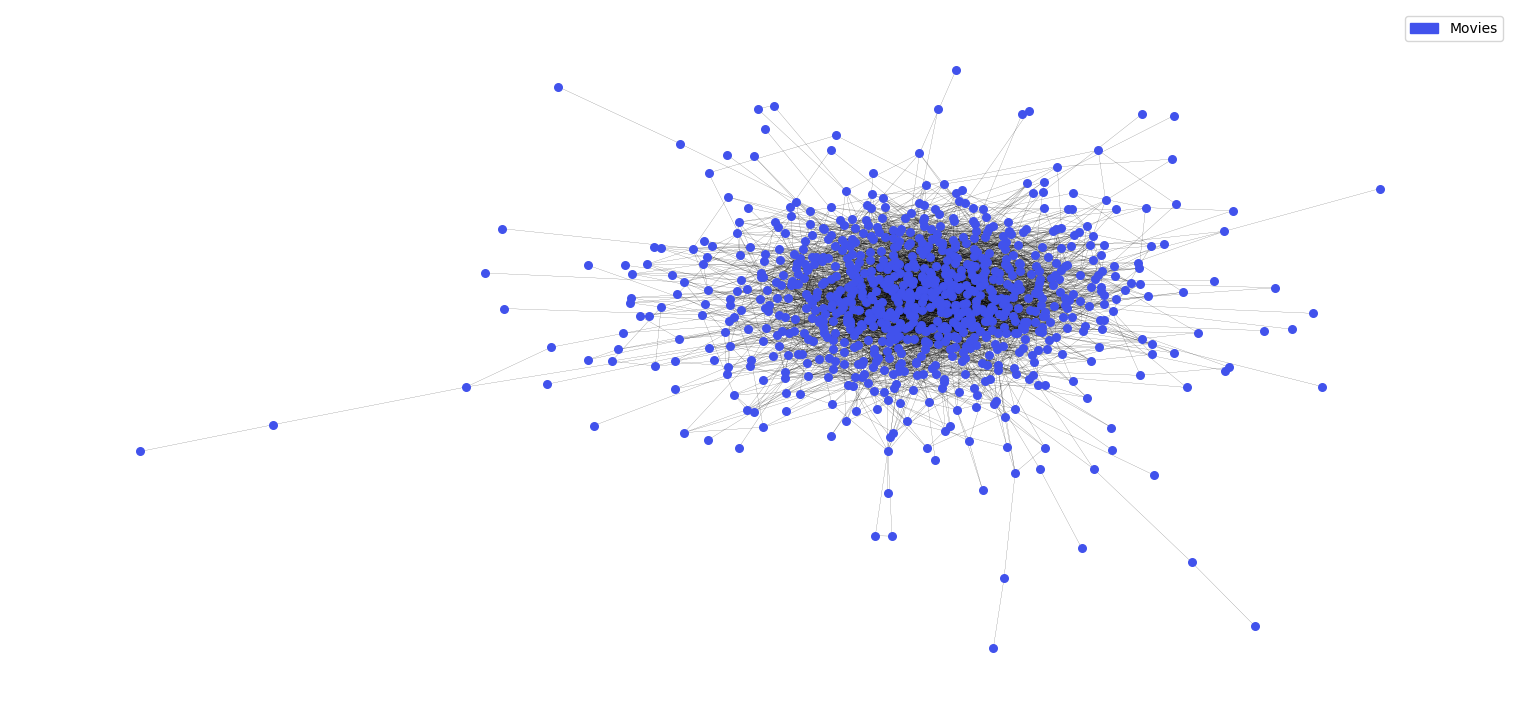

In [11]:
# Layout
plt.figure(figsize=(15, 7))
pos = nx.spring_layout(G_movies_lcc)

# Draw network
nx.draw(G_movies_lcc, pos, node_color=d_color, edge_color='black', with_labels=False, node_size=30, width=0.1)

# Legend
movies_patch = mpatches.Patch(color=d_color, label='Movies')
plt.legend(handles=[movies_patch])

plt.show()

In [12]:
n, m = len(G_movies.nodes()), len(G_movies.edges())
print('Nb nodes: n =', n)
print('Nb edges: m =', m)

Nb nodes: n = 936
Nb edges: m = 4586


## **Communities**

In [13]:
# comparing with NetworkX
nx_communities = nx.algorithms.centrality.edge_betweenness_centrality(G_movies)

nx_girvan_newman = nx.algorithms.community.centrality.girvan_newman(G_movies)

nx_best_community = tuple(sorted(c) for c in next(nx_girvan_newman))
print('Comparing best communities:')
print('\t- NetworkX:', nx_best_community)

nx_modularity_G = nx.algorithms.community.quality.modularity(G_movies, nx_best_community)
print('\nComparing Modularity:')
print('\t- NetworkX:', nx_modularity_G)

Comparing best communities:
	- NetworkX: (['102 Dalmatians', '11:14', '13 Going on 30', '2 Fast 2 Furious', '21 Grams', '25th Hour', '28 Days', '28 Days Later', '3 Strikes', '3000 Miles to Graceland', '40 Days and 40 Nights', '50 First Dates', '8 Mile', '8 Women', 'A Beautiful Mind', 'A Cinderella Story', 'A Guy Thing', 'A Home at the End of the World', "A Knight's Tale", 'A Lot Like Love', 'A Man Apart', 'A Mighty Wind', 'A Very Long Engagement', 'A Walk to Remember', 'A.I. Artificial Intelligence', 'Abandon', 'Abandoned', 'Aberdeen', 'About Schmidt', 'About a Boy', 'After the Sunset', 'Against the Ropes', 'Agent Cody Banks', 'Agent Cody Banks 2: Destination London', 'Alfie', 'Ali', 'Alive', 'All About the Benjamins', 'All or Nothing', 'All the Pretty Horses', 'All the Real Girls', 'Almost Famous', 'Alone in the Dark', 'Along Came Polly', 'Along Came a Spider', 'Amen.', "America's Sweethearts", 'American Desi', 'American Outlaws', 'American Pie 2', 'American Psycho', 'American Splendo

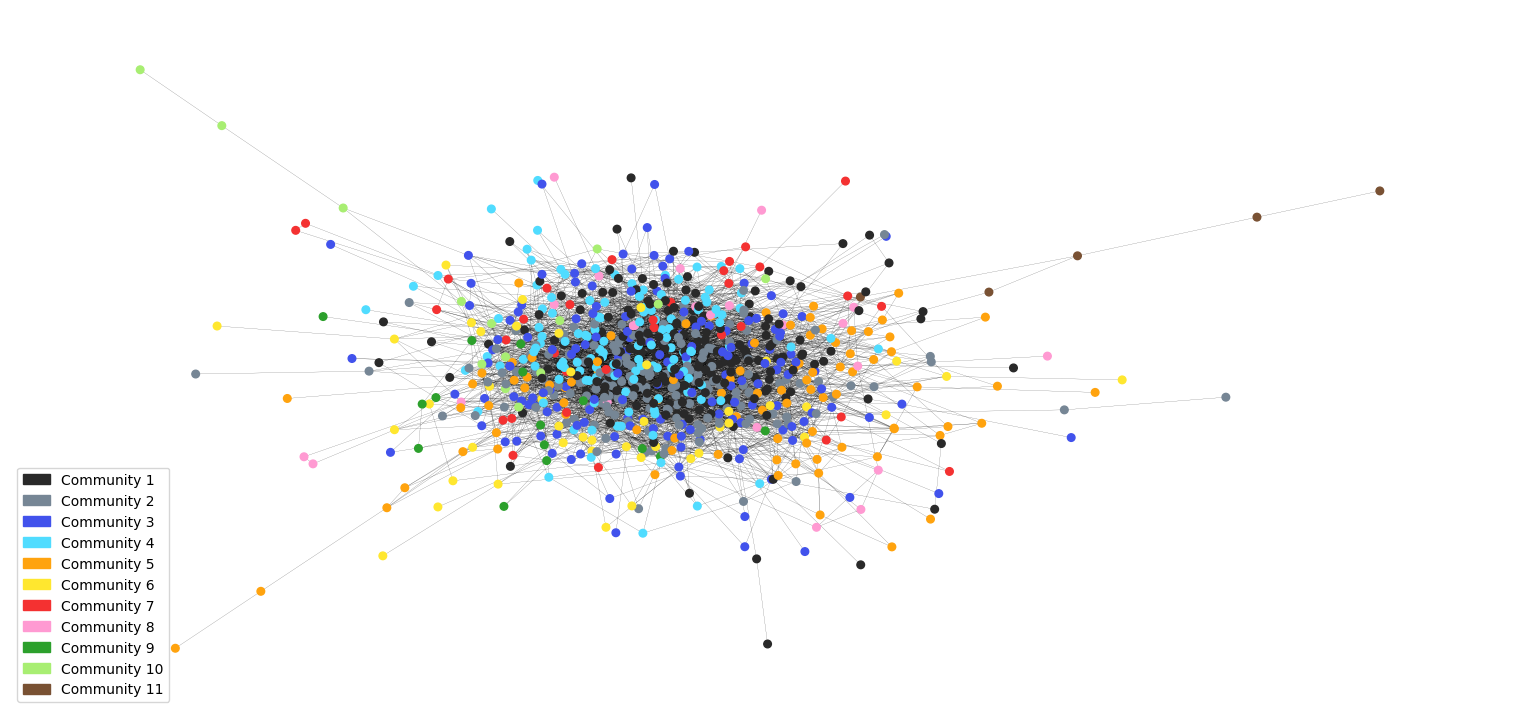

In [14]:
# Communities
communities = nx.algorithms.community.greedy_modularity_communities(G_movies_lcc)

# Plot
plt.figure(figsize=(15, 7))
pos = nx.spring_layout(G_movies_lcc)
color_map = {node: colors[i % len(colors)] for i, community in enumerate(communities) for node in community}
nx.draw(G_movies_lcc, pos, node_color=[color_map[node] for node in G_movies_lcc.nodes], edge_color='black', with_labels=False, node_size=30, width=0.1)
patches = [mpatches.Patch(color=colors[i % len(colors)], label=f'Community {i+1}') for i in range(len(communities))]
plt.legend(handles=patches)
plt.show()


In [15]:
# Number of Movies in Each Community
for i, community in enumerate(communities, start=1):
    print(f'Community {i}: \t {len(community)} movies')

Community 1: 	 183 movies
Community 2: 	 164 movies
Community 3: 	 154 movies
Community 4: 	 126 movies
Community 5: 	 90 movies
Community 6: 	 44 movies
Community 7: 	 33 movies
Community 8: 	 23 movies
Community 9: 	 15 movies
Community 10: 	 14 movies
Community 11: 	 5 movies


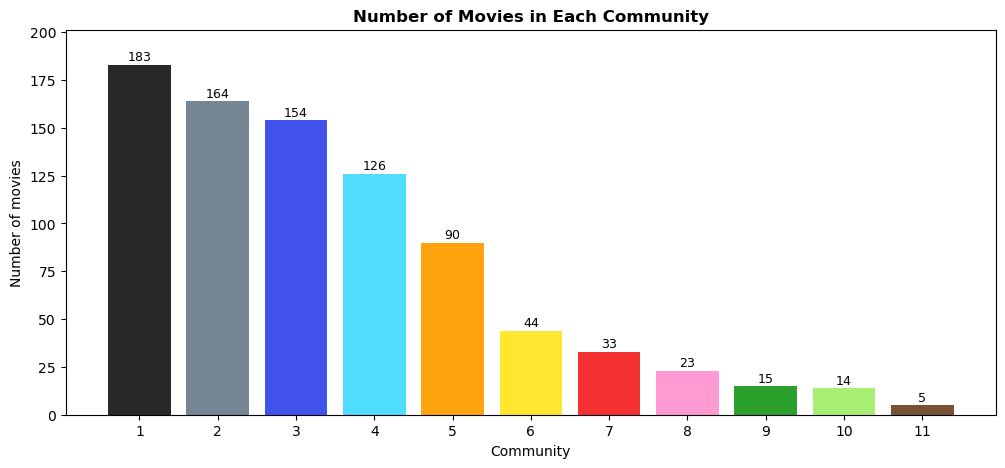

In [16]:
# Number of movies in each community
num_movies = [len(community) for community in communities]

# Histogram
plt.figure(figsize=(12, 5))
bars = plt.bar(range(1, len(communities) + 1), num_movies, color=[colors[i % len(colors)] for i in range(len(communities))])
plt.xticks(range(1, len(communities) + 1))
plt.ylim(0, max(num_movies) + (max(num_movies)/10))
plt.xlabel('Community')
plt.ylabel('Number of movies')
plt.title('Number of Movies in Each Community', fontweight='bold')

# Add the precise number of movies above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom', fontsize=9)

plt.show()


In [17]:
# Number of Movies in Each Community and their titles
for i, community in enumerate(communities, start=1):
    print(f'Community {i}:')
    for movie in community:
        print(f'\t- {movie}')
    print('\n')


Community 1:
	- The Patriot
	- Anastasia
	- Crazy/Beautiful
	- The Perfect Storm
	- Brothers
	- Jeepers Creepers
	- Master and Commander: The Far Side of the World
	- The Crime of Padre Amaro
	- Elf
	- Dancer in the Dark
	- Pollock
	- The New Guy
	- Harry Potter and the Prisoner of Azkaban
	- Hardball
	- The Musketeer
	- The Road to El Dorado
	- Eye of the Beholder
	- Veronica Guerin
	- Star Trek: Nemesis
	- Mulholland Drive
	- Eternal Sunshine of the Spotless Mind
	- Pieces of April
	- X-Men
	- The Statement
	- Catch That Kid
	- Kate & Leopold
	- The Forsaken
	- Black Hawk Down
	- The Calling
	- The Four Feathers
	- Ghost Dog: The Way of the Samurai
	- Swept Away
	- Red Riding Hood
	- Me and You and Everyone We Know
	- Rock Star
	- Hamlet
	- The Jungle Book 2
	- The Punisher
	- Mystic River
	- The Next Best Thing
	- Coyote Ugly
	- 8 Women
	- Miss Congeniality
	- Miss Congeniality 2: Armed and Fabulous
	- The Order
	- Divine Secrets of the Ya-Ya Sisterhood
	- Gladiator
	- Battlefield E

## **Degrees**
- A high degree count for a movie means that the movie shares a significant number of actors with many other movies. This means that many of the actors in the movie have also acted in a large number of other movies in the network. This could indicate that the movie has a well-known or versatile cast.

In [18]:
# Both old and new users
degrees = G_movies.degree()
top_10_movies_degree = sorted(degrees, key=lambda x: x[1], reverse=True)[:10]
for movie, degree in top_10_movies_degree:
    print(f'{movie}: {degree}')

Shark Tale: 33
The Italian Job: 29
Men of Honor: 28
Nurse Betty: 28
Pearl Harbor: 27
Vanilla Sky: 27
Meet the Parents: 27
Batman Begins: 26
High Crimes: 26
Charlie's Angels: Full Throttle: 25


## **Betweenness centrality**
- Betweenness centrality is a measure of a node’s centrality in a network. It is equal to the number of shortest paths from all vertices to all others that pass through that node. A higher betweenness centrality generally means that a node is more central in the network.
- Maybe use for new users (no movies seen yet). The movies with high betweenness centrality would be good for new users as the movies are connected to many other movies in the network through shared actors. 

In [19]:
# Use for new users maybe
centrality = nx.betweenness_centrality(G_movies)
top_10_movies_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for movie, centrality in top_10_movies_centrality:
    print(f'{movie}: {centrality}')

The Italian Job: 0.01295773761848073
Vanilla Sky: 0.011669802477575625
High Crimes: 0.011581943660039548
Shark Tale: 0.009823422719670495
Nurse Betty: 0.009812055980097987
Pearl Harbor: 0.009391112208518262
Batman Begins: 0.008989144223062975
Envy: 0.008896221618697768
Men of Honor: 0.008793986081146139
The Yards: 0.008785624073374017


## **Recommend movies based on communites**
- Sort these movies based on number of common actors

In [20]:
# Should have seen at least one movie. Recommend based on latest seen movie.
def top_10_movies_common_actors(movie_title, G_movies):
    given_movie_actors = set(G_movies.nodes[movie_title]['actors'])

    # Number of common actors for each movie
    common_actors = {movie: len(given_movie_actors & set(G_movies.nodes[movie]['actors'])) for movie in G_movies.nodes if movie != movie_title}
    common_actors = {movie: actors for movie, actors in common_actors.items() if actors > 0}
    if not common_actors:
        print(f'No movies found with common actors to "{movie_title}".')
        return []
    sorted_movies = sorted(common_actors.items(), key=lambda x: x[1], reverse=True)
    top_movies = sorted_movies

    return top_movies

In [21]:
def print_movie_community(movie_title, communities):
    for i, community in enumerate(communities, start=1):
        if movie_title in community:
            print(f'"{movie_title}" is in Community {i}. These are the top 10 recommended movies with common actors:')
            sorted_movies = top_10_movies_common_actors(movie_title, G_movies)
            sorted_movies = [movie for movie in sorted_movies if movie[0] in community]
            for movie, common_actors in sorted_movies:
                print(f'\t- {movie}: {common_actors}')
            if len(sorted_movies) < 10:
                print(f'\nNote: There are only {len(sorted_movies)} movies with common actors to "{movie_title}".')
            break
    else:
        print(f'"{movie_title}" is not found in any community.')


In [22]:
print_movie_community("The Italian Job", communities)

"The Italian Job" is in Community 4. These are the top 10 recommended movies with common actors:
	- Red Dragon: 1
	- The Score: 1
	- Death to Smoochy: 1
	- Sweet November: 1
	- Reindeer Games: 1
	- Men of Honor: 1
	- Keeping the Faith: 1
	- Monster: 1
	- 25th Hour: 1

Note: There are only 9 movies with common actors to "The Italian Job".


In [475]:
def get_movie_community_df(movie_title):
    # Find community of the given movie
    for community in communities:
        if movie_title in community:
            df_tmdb_community = df_tmdb[df_tmdb['title'].isin(community)] # Filter dataframe so it only includes the movies in the community of the input movie           
            return df_tmdb_community

    print(f'"{movie_title}" is not found in any community.')
    return pd.DataFrame()

movieTitle = "The Italian Job"
df_tmdb_new = get_movie_community_df(movieTitle)
df_tmdb_new

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
5,110,140000000,"[{""id"": 36, ""name"": ""History""}, {""id"": 10749, ...",NaN,676,"[{""id"": 428, ""name"": ""nurse""}, {""id"": 1627, ""n...",en,Pearl Harbor,The lifelong friendship between Rafe McCawley ...,34.206690,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2001-05-21,449220945,183.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,It takes a moment to change history. It takes ...,Pearl Harbor,6.6,1791
19,194,127500000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",NaN,10567,"[{""id"": 843, ""name"": ""cataclysm""}, {""id"": 1423...",en,Dinosaur,An orphaned dinosaur raised by lemurs joins an...,26.548594,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2000-05-19,354248063,82.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,You have never seen anything like this.,Dinosaur,6.2,542
36,272,90000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,24113,"[{""id"": 2301, ""name"": ""architect""}, {""id"": 345...",en,Town & Country,Porter Stoddard is a well-known New York archi...,1.004579,...,[],2001-04-27,10372291,104.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,There's no such thing as a small affair.,Town & Country,3.7,16
56,339,92000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://disney.go.com/disneyvideos/animatedfilm...,9806,"[{""id"": 1308, ""name"": ""secret identity""}, {""id...",en,The Incredibles,Bob Parr has given up his superhero days to lo...,77.817571,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2004-11-05,631442092,115.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,"No gut, no glory",The Incredibles,7.4,5152
79,412,60000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",NaN,9341,"[{""id"": 5178, ""name"": ""magnetic field""}, {""id""...",en,The Core,Geophysicist Dr. Josh Keyes discovers that an ...,29.211255,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-03-28,74208267,136.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Earth has a deadline.,The Core,5.4,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,3864,3000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",NaN,13973,"[{""id"": 3688, ""name"": ""strip club""}, {""id"": 59...",en,Choke,A sex-addicted con-man pays for his mother's h...,11.637458,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2008-09-26,3830137,92.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,From the author of Fight Club,Choke,6.0,127
696,3891,4000000,"[{""id"": 99, ""name"": ""Documentary""}]",http://www.bowlingforcolumbine.com/index.php,1430,"[{""id"": 279, ""name"": ""usa""}, {""id"": 1329, ""nam...",en,Bowling for Columbine,"Why do 11,000 people die in America each year ...",11.414843,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-10-09,35564473,120.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,One nation under the gun.,Bowling for Columbine,7.3,453
715,4190,500000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 27, ""name...",NaN,10894,"[{""id"": 2467, ""name"": ""difficult childhood""}, ...",en,May,Psychological horror about a lonely young woma...,8.650779,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-01-13,150277,93.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Be Careful... She Just Might Take Your Heart.,May,6.3,152
725,4291,1200000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 9648, ""n...",NaN,176,"[{""id"": 1366, ""name"": ""shotgun""}, {""id"": 13000...",en,Saw,Obsessed with teaching his victims the value o...,63.655973,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",20

---
# **Topic Modelling**
---

In [476]:
#dataframe with only genres, keywords, overview and tagline
movie_text = df_tmdb[['genres', 'keywords', 'overview', 'tagline']]


## **Text preprocessing**
The text preprocessing with be done with df_tmdb, which is all movies from 2000 or later, that is also in the ratings dataset.

In [477]:
#convert from string to list
movie_text['genres'] = movie_text['genres'].apply(json.loads)
movie_text['keywords'] = movie_text['keywords'].apply(json.loads)

In [478]:
def convertJSON(df, column): #column as string
    columnDict = {}
    for i in range(0,len(df)): #loop through index
        columnList = []
        for j in range(0, len(df[column][i])): #loop through column for that row
            columnList.append(df[column][i][j]['name'])
        columnDict[i] = ', '.join(columnList)
        
    return columnDict

In [479]:
#convert from json
genreDict = convertJSON(movie_text, 'genres')
keywordsDict = convertJSON(movie_text, 'keywords')

In [480]:
#add to dataframe
movie_text['genres'] = genreDict.values()
movie_text['keywords'] = keywordsDict.values()
movie_text

,genres,keywords,overview,tagline
0,"Animation, Family","hostage, magic, horse, fairy tale, musical, pr...",When the kingdom's most wanted-and most charmi...,They're taking adventure to new lengths.
1,"Action, Adventure, Fantasy","dual identity, love of one's life, pizza boy, ...",Peter Parker is going through a major identity...,There's a hero in all of us.
2,"Drama, Romance","based on novel, infidelity, obsession, hope, 3d",An adaptation of F. Scott Fitzgerald's Long Is...,Reserving judgments is a matter of infinite ho...
3,"Action, Thriller, Science Fiction","saving the world, artificial intelligence, man...",It's been 10 years since John Connor saved Ear...,The Machines Will Rise.
4,"Action, Crime, Thriller","street gang, car race, undercover, auto-tuning...",Domenic Toretto is a Los Angeles street racer ...,Live life 1/4 mile at a time.
...,...,...,...,...
748,"Music, Drama",independent film,"Seymour Polatkin is a successful, gay Indian p...",Sometimes going home is the hardest journey of...
749,"Comedy, Drama, Romance",independent film,"Beautiful, sophisticated women are all over Os...",Everyone says he should date girls his own age...
750,"Comedy, Horror, Science Fiction","monster, mutant, skeleton, alien life-form, sc...",Remember the good old days when anyone with a ...,No One Can Stand Its Mental Power!
751,"Documentary, Comedy, Drama","experiment, health, junk food, food industry, ...",Morgan Spurlock subjects himself to a diet bas...,The first ever reality-based movie ... everyth...


Now that the text is on the right format, we will do some more preprocessing. For that, the function `preProcess`, is created. This function make text to lowercase, remove stop words, remove punctuation and lemmatize the text. Stopwords will be removed before removing punctuation. It is important to remove stop words before punctuation, since some words will no longer be a stop word, if punctuation is removed before stop words.
Lemmatization is used instead of stemming because the lemmatization uses lexical knowledge base to get base form of words insteaf of cutting the last part of the [word](https://medium.com/product-ai/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908). 

In [481]:
def removeStopWords(string):
    new_string = []
    stopWords = stopwords.words('english')
    
    for s in string.split():
        if s not in stopWords:
            new_string.append(s)
    final_string = ' '.join(new_string)
    
    return final_string

In [482]:
def remove(string, regex):
    result = re.sub(regex, '', string)
    
    return result

In [483]:
def removePunctuation(string): #remove: . , ! ? ' ’ : " ( ) $ - and numbers
    reg = [r'\.', r'\,', r'\?', r'\'', r'’', r'\"', r':', r':', r'\(', r'\)', r'\$', r'-', r'\d'] 

    for r in reg:
        string = remove(string, r)
        
    return string


#remove stopwords and split

In [484]:
def lemmatize(string):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    
    for w in string.split():
        lemmatized_words.append(lemmatizer.lemmatize(w))
    lemmatized_sentence = ' '.join(lemmatized_words)
    
    return lemmatized_sentence

In [485]:
def preProcess(df):
    for col in df.columns:
        lower = df[col].str.lower() #lowercase
        removeStopW = lower.apply(lambda x: removeStopWords(x)) #remove stop words
        removePunct = removeStopW.apply(lambda x: removePunctuation(x)) #remove punctuation
        df[(col)] = removePunct.apply(lambda x: lemmatize(x)) #lemmatize
 
    return df

In [486]:
#preprocessed text
df_preprocessed = preProcess(movie_text)
df_preprocessed

,genres,keywords,overview,tagline
0,animation family,hostage magic horse fairy tale musical princes...,kingdom wantedand charmingbandit flynn rider h...,theyre taking adventure new length
1,action adventure fantasy,dual identity love one life pizza boy marvel c...,peter parker going major identity crisis burne...,there hero u
2,drama romance,based novel infidelity obsession hope d,adaptation f scott fitzgerald long islandset n...,reserving judgment matter infinite hope come a...
3,action thriller science fiction,saving world artificial intelligence man v mac...,year since john connor saved earth judgment da...,machine rise
4,action crime thriller,street gang car race undercover autotuning los...,domenic toretto los angeles street racer suspe...,live life / mile time
...,...,...,...,...
748,music drama,independent film,seymour polatkin successful gay indian poet sp...,sometimes going home hardest journey all
749,comedy drama romance,independent film,beautiful sophisticated woman oscar grubman se...,everyone say date girl age oscar respectfully ...
750,comedy horror science fiction,monster mutant skeleton alien lifeform science,remember good old day anyone camera thousand b...,one stand mental power!
751,documentary comedy drama,experiment health junk food food industry fast...,morgan spurlock subject diet based mcdonalds f...,first ever realitybased movie everything begin...


In [487]:
#get all text into a list. Each document/movie is splitted by comma
overview =  ','.join(df_preprocessed.overview).split(',') 
tagline = ','.join(df_preprocessed.tagline).split(',')
genre = ','.join(df_preprocessed.genres).split(',')
keywords = ','.join(df_preprocessed.keywords).split(',')

#get a lis of list, where each list is a document/movie. Each word is as individually string
#get each string into array.
overviewText = [d.split() for d in overview]
taglineText = [d.split() for d in tagline]
genreText = [d.split() for d in genre]
keywordsText = [d.split() for d in keywords]

#create dictionary
overview_dict = corpora.Dictionary(overviewText)
tagline_dict = corpora.Dictionary(taglineText)
genre_dict = corpora.Dictionary(genreText)
keywords_dict = corpora.Dictionary(keywordsText)

#create corpus
overviewCorpus = [overview_dict.doc2bow(text) for text in overviewText]
taglineCorpus = [tagline_dict.doc2bow(text) for text in taglineText]
genreCorpus = [genre_dict.doc2bow(text) for text in genreText]
keywordsCorpus = [keywords_dict.doc2bow(text) for text in keywordsText]

## **TF-IDF**
Now that the text is preprocessed, we will start to look at the preprocessed text, starting with TF-IDF. This shows the words, that tells most about the movies/text about the movies. Meaning that it will not show the words that are often in a lot of movies. 

There are several kinds of TF-IDF, but here will be used the one taught in class. 

In [488]:
def tf_idf(corpus, dictionary, documents):
    N = len(corpus) #number of documents
    f = np.zeros((len(documents), len(dictionary)))#matrix in size: number of documents x number of unique words in all documents
    tf = np.zeros((len(documents), len(dictionary)))#matrix in size: number of documents x number of unique words in all documents
    n_t = np.zeros(len(dictionary)) #array for counting number of documents word t appears in
    
    #for d in documents: #loop through all documents
    for d in range(0,len(documents)):
        for key in dictionary.keys(): #loop through all words
            word = dictionary[key]
            wordCount = documents[d].count(word) #count occurence of word in each document
            f[d, key] = wordCount
            
            if wordCount >= 1: #if word is in document, add 1 to document count
                n_t[key] += 1 
            
        tf[d,:] = f[d,:]/max(f[d,:]) 
    
    idf = np.log2((N/n_t))
    TF_IDF = tf * idf
   
    return TF_IDF

In [489]:
TF_IDF_overview = tf_idf(overviewCorpus, overview_dict, overview)
TF_IDF_tagline = tf_idf(taglineCorpus, tagline_dict, tagline)
TF_IDF_genre = tf_idf(genreCorpus, genre_dict, genre)
TF_IDF_keywords = tf_idf(keywordsCorpus, keywords_dict, keywords)

## **Wordcloud**
Now, we plot a wordcloud, one for each of the text columns; overview, tagline, genres and keywords. 

In [490]:
def wordCloud(df, column):
    text = ' '.join(df[column])
    
    wordcloud = WordCloud().generate(text)
    return wordcloud

In [491]:
wordcloud_overview = wordCloud(df_preprocessed, 'overview')
wordcloud_tagline = wordCloud(df_preprocessed, 'tagline')
wordcloud_genre_text = wordCloud(df_preprocessed, 'genres')
wordcloud_keywords_text = wordCloud(df_preprocessed, 'keywords')

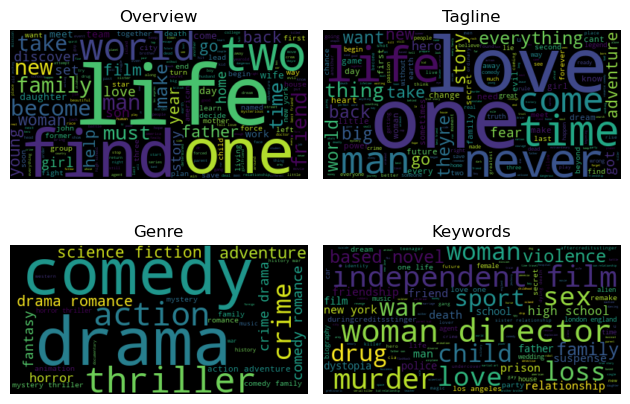

In [492]:
plt.subplots(nrows=2, ncols=2)
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_overview, interpolation = 'bilinear')
plt.axis("off")
plt.title("Overview")

plt.subplot(2, 2, 2)
plt.imshow(wordcloud_tagline, interpolation = 'bilinear')
plt.axis("off")
plt.title("Tagline")

plt.subplot(2, 2, 3)
plt.imshow(wordcloud_genre_text, interpolation = 'bilinear')
plt.axis("off")
plt.title("Genre")

plt.subplot(2, 2, 4)
plt.imshow(wordcloud_keywords_text, interpolation = 'bilinear')
plt.axis("off")
plt.title("Keywords")


plt.tight_layout()
plt.show()

In [493]:
def frequency(TF_IDF_array, dictionary):
    frequency_dict = {}
    for i in range(0, len(dictionary)):
        frequency_dict[dictionary[i]] = np.sum(TF_IDF_array[:,i])
    return frequency_dict

In [494]:
#create dict with frequency of TF-IDF
overviewFrequency = frequency(TF_IDF_overview, overview_dict)
taglineFrequency = frequency(TF_IDF_tagline, tagline_dict)
genreFrequency = frequency(TF_IDF_genre, genre_dict)
keywordsFrequency = frequency(TF_IDF_keywords, keywords_dict)

In [495]:
#create wordclouds for TF-IDF
overviewWordcloud = WordCloud().generate_from_frequencies(frequencies = overviewFrequency)
taglineWordcloud = WordCloud().generate_from_frequencies(frequencies = taglineFrequency)
genreWordcloud = WordCloud().generate_from_frequencies(frequencies = genreFrequency)
keywordsWordcloud = WordCloud().generate_from_frequencies(frequencies = keywordsFrequency)

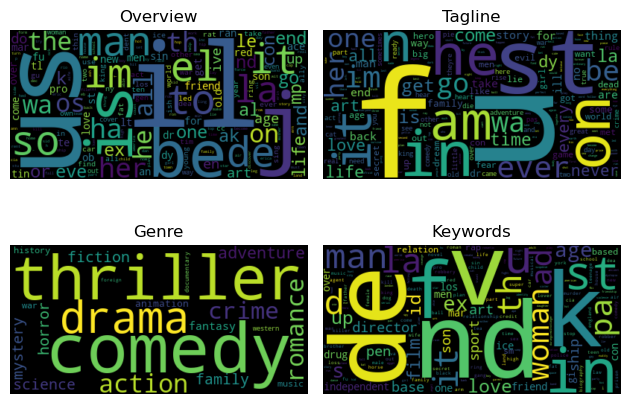

In [496]:
plt.subplots(nrows=2, ncols=2)
plt.subplot(2, 2, 1)
plt.imshow(overviewWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Overview")

plt.subplot(2, 2, 2)
plt.imshow(taglineWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Tagline")

plt.subplot(2, 2, 3)
plt.imshow(genreWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Genre")

plt.subplot(2, 2, 4)
plt.imshow(keywordsWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Keywords")


plt.tight_layout()
plt.show()

In [497]:
def getImportantWords(tf_idf, corpus, dictionary): #find 10 most important words based on TF-IDF
    important_words = []
    for d in range(0,len(corpus)):
        index_largest = tf_idf[d,:].argsort()[-10:]
        important_words.append([dictionary[i] for i in index_largest])
        
    return important_words

In [498]:
#get 10 most important words for each movie
importantWords_overview = getImportantWords(TF_IDF_overview, overviewCorpus, overview_dict)
importantWords_tagline = getImportantWords(TF_IDF_tagline, taglineCorpus, tagline_dict)
importantWords_genre = getImportantWords(TF_IDF_genre, genreCorpus, genre_dict)
importantWords_keywords = getImportantWords(TF_IDF_keywords, keywordsCorpus, keywords_dict)

In [499]:
#create corpus from important words
overviewCorpus_importantW =  [overview_dict.doc2bow(text) for text in importantWords_overview]
taglineCorpus_importantW =  [tagline_dict.doc2bow(text) for text in importantWords_tagline]
genreCorpus_importantW =  [genre_dict.doc2bow(text) for text in importantWords_genre]
keywordsCorpus_importantW =  [keywords_dict.doc2bow(text) for text in importantWords_keywords]

## **LDA**
Now for the actual topic modeeling, which is performed using Latent Dirichlet Allocation(LDA). The implementation is performed with inspiration from [this](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) article. To perform LDA, we need to know the number of topics. There are different ways to investigate this, but here we have chosen to try different number of topics, and check how the topics look, and how it looks when plotted. We want the topic to represent different topics, however we also decided to have a criteria, that there should be at least 5 movies in each topic. However, the recommender system is performed in a way, so we first find the community we are looking for a movie in. Therefore, we are performing LDA on a community, which means that there need to be at least 5 movies in each topic in each community. This was checked before choosing the number of topics. Since LDA is performed on a community, we need to define the dictionary and corpus for the community instead of all movies. It was tried to perform topic modelling with overview, keywords, tagline and genres. In the end, it was decided to use the genres in the beginning, and not in the topic modelling. It was also decided not to use tagline, since it didn't really explain a lot about the movies, so we didn't think it was a good attribute, to base a recommendation on. 

Looking at the wordclouds with and without TF-IDF, it seems that the words in TF-IDF doesn't really make any sense. It could indicate some problem in the preprocessing. Due to the result, we have chosen to the LDA on only the text without TF-IDF, since we believe this will give us the best recomendations. 

In [543]:
c = 3
movie = list(communities[c])[0]
df_tmdb_new = get_movie_community_df(movie) #the first 3 lines, should be deleted

#7, 8, 9, 10, 11

communityIndex = df_tmdb_new.index.to_list()
len(df_tmdb_new)

#c = 0, 1,2 

107

In [545]:
communityText = df_preprocessed.iloc[communityIndex]

In [546]:
#get all text into a list. Each document/movie is splitted by comma
overview_c = ','.join(communityText.overview).split(',') 
tagline_c = ','.join(communityText.tagline).split(',') 
genre_c = ','.join(communityText.genres).split(',') 
keywords_c = ','.join(communityText.keywords).split(',') 


#get a lis of list, where each list is a document/movie. Each word is as individually string
#get each string into array.
overview_cText = [d.split() for d in overview_c]
tagline_cText = [d.split() for d in tagline_c]
genre_cText = [d.split() for d in genre_c]
keywords_cText = [d.split() for d in keywords_c]

#create dictionary
overview_cDict = corpora.Dictionary(overview_cText)
tagline_cDict = corpora.Dictionary(tagline_cText)
genre_cDict = corpora.Dictionary(genre_cText)
keywords_cDict = corpora.Dictionary(keywords_cText)

#create corpus
overviewC_Corpus = [overview_cDict.doc2bow(text) for text in overview_cText]
taglineC_Corpus = [tagline_cDict.doc2bow(text) for text in tagline_cText]
genreC_Corpus = [genre_cDict.doc2bow(text) for text in genre_cText]
keywordsC_Corpus = [keywords_cDict.doc2bow(text) for text in keywords_cText]

In [547]:
#number of topics assigned is the such that there on average is 9 movies per topic for overview and 10 movies for keywords
n_topics_overview = int(np.floor(len(df_tmdb_new)/10))
n_topics_keywords = int(np.floor(len(df_tmdb_new)/11))

In [548]:
def LDA(n_topics, corpus, dictionary): #create function for LDA
    lda = gensim.models.LdaMulticore(corpus = corpus,
                                       id2word=dictionary,
                                       num_topics=n_topics)
    return lda

In [549]:
def LDA_plot(path, lda_model, corpus, dictionary, n_topics):
    #Visualize topics
    pyLDAvis.enable_notebook()
    LDAvis_data_filepath = os.path.join(path + str(n_topics))
    
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
            
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
        
    pyLDAvis.save_html(LDAvis_prepared, path+ str(n_topics) +'.html')
    
    return LDAvis_prepared 

In [550]:
#create LDA
overviewLDA = LDA(n_topics_overview, overviewC_Corpus, overview_cDict)
keywordsLDA = LDA(n_topics_keywords, keywordsC_Corpus, keywords_cDict)

In [551]:
#create plots
overviewLDA_plot = LDA_plot('results/ldavis_prepared_', overviewLDA, overviewC_Corpus, overview_cDict, n_topics_overview)
keywordsLDA_plot = LDA_plot('results/ldavis_prepared_', keywordsLDA, keywordsC_Corpus, keywords_cDict, n_topics_keywords)

In [552]:
# Print the Keyword in the 10 topics for overview
pprint(overviewLDA.print_topics())

[(0,
  '0.007*"u" + 0.006*"wife" + 0.006*"new" + 0.005*"home" + 0.005*"hole" + '
  '0.005*"agent" + 0.005*"one" + 0.004*"first" + 0.004*"navy" + 0.004*"sight"'),
 (1,
  '0.007*"life" + 0.005*"team" + 0.005*"school" + 0.005*"tv" + 0.005*"help" + '
  '0.005*"high" + 0.005*"star" + 0.005*"world" + 0.004*"core" + 0.004*"take"'),
 (2,
  '0.009*"job" + 0.008*"get" + 0.006*"tom" + 0.005*"one" + 0.005*"silver" + '
  '0.005*"team" + 0.005*"he" + 0.005*"find" + 0.005*"–" + 0.004*"best"'),
 (3,
  '0.011*"life" + 0.007*"one" + 0.007*"chon" + 0.005*"brother" + 0.005*"first" '
  '+ 0.005*"day" + 0.005*"joel" + 0.005*"nelson" + 0.004*"killer" + '
  '0.004*"must"'),
 (4,
  '0.017*"life" + 0.006*"eve" + 0.006*"oscar" + 0.006*"two" + 0.006*"victim" + '
  '0.005*"must" + 0.005*"face" + 0.005*"love" + 0.004*"child" + 0.004*"new"'),
 (5,
  '0.005*"one" + 0.005*"man" + 0.005*"jimmy" + 0.005*"must" + 0.005*"face" + '
  '0.005*"life" + 0.005*"wife" + 0.004*"seek" + 0.004*"mother" + '
  '0.004*"mission"'),
 (6

In [553]:
# Print the Keyword in the 10 topics for keywords
pprint(keywordsLDA.print_topics())

[(0,
  '0.017*"love" + 0.014*"city" + 0.014*"new" + 0.014*"show" + 0.009*"film" + '
  '0.009*"singer" + 0.009*"music" + 0.009*"model" + 0.009*"fashion" + '
  '0.009*"york"'),
 (1,
  '0.011*"identity" + 0.011*"american" + 0.009*"killer" + 0.009*"dream" + '
  '0.009*"wedding" + 0.007*"surveillance" + 0.007*"police" + 0.007*"blackmail" '
  '+ 0.007*"agent" + 0.007*"secret"'),
 (2,
  '0.016*"airplane" + 0.009*"lost" + 0.009*"black" + 0.008*"police" + '
  '0.008*"wedding" + 0.008*"sex" + 0.008*"baggage" + 0.008*"ambulance" + '
  '0.008*"volleyball" + 0.008*"crash"'),
 (3,
  '0.015*"war" + 0.013*"tv" + 0.013*"based" + 0.012*"brother" + 0.012*"car" + '
  '0.011*"police" + 0.010*"film" + 0.010*"nudity" + 0.008*"relationship" + '
  '0.008*"drug"'),
 (4,
  '0.020*"prehistoric" + 0.013*"family" + 0.008*"dance" + 0.008*"comedy" + '
  '0.008*"risk" + 0.008*"chance" + 0.008*"sport" + 0.007*"war" + '
  '0.007*"aspiring" + 0.006*"blackmail"'),
 (5,
  '0.015*"film" + 0.010*"lawyer" + 0.010*"u" + 0.010*

In [554]:
#plot topics for overview
overviewLDA_plot 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.043744 -0.115942       1        1  13.660874
4     -0.021591 -0.019215       2        1  13.452504
3      0.058220  0.087449       3        1  12.394353
1     -0.071575  0.076038       4        1  11.485723
7      0.074693 -0.026515       5        1  11.461853
2     -0.083512 -0.010496       6        1   8.941198
0      0.041640  0.006330       7        1   8.295953
6     -0.081111 -0.055344       8        1   8.258410
9      0.047560  0.032806       9        1   6.850814
5     -0.008068  0.024889      10        1   5.198316, topic_info=        Term       Freq      Total Category  logprob  loglift
298     work   5.000000   5.000000  Default  30.0000  30.0000
518      job   4.000000   4.000000  Default  29.0000  29.0000
692     chon   3.000000   3.000000  Default  28.0000  28.0000
572     life  26.000000  26.000000  Default  27.0000  27.0000
259   killer   6.000000   6.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
897   people   0.506970   3.582454  Topic10  -5.8918   1.0015
10   fighter   0.474222   2.779007  Topic10  -5.9586   1.1887
84       get   0.522533   8.643464  Topic10  -5.8616   0.1510
806     tell   0.499656   5.404091  Topic10  -5.9063   0.5758
803    story   0.504928   6.544974  Topic10  -5.8958   0.3948

[602 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         8  0.857326        ace
184       7  0.461193     action
184      10  0.461193     action
772       4  0.541477  affection
250       1  0.169571      agent
...     ...       ...        ...
389       9  0.122671      young
531       1  0.225604          –
531       4  0.225604          –
531       6  0.225604          –
531       8  0.225604          –

[824 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 4, 2, 8, 3, 1, 7, 10, 6])

In [555]:
#plot topics for keywords
keywordsLDA_plot 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.001909  0.081368       1        1  17.734994
8     -0.136417 -0.002965       2        1  17.079990
1      0.144842  0.027009       3        1  15.217921
4     -0.060121  0.091943       4        1  13.723989
0      0.001259 -0.124739       5        1  11.312461
5     -0.012514 -0.075033       6        1   8.124297
7      0.030039 -0.012503       7        1   7.117511
6      0.027731  0.024560       8        1   5.483012
2      0.003273 -0.009641       9        1   4.205826, topic_info=             Term      Freq     Total Category  logprob  loglift
77         killer  6.000000  6.000000  Default  30.0000  30.0000
75          agent  4.000000  4.000000  Default  29.0000  29.0000
79         serial  4.000000  4.000000  Default  28.0000  28.0000
66   relationship  8.000000  8.000000  Default  27.0000  27.0000
76            fbi  3.000000  3.000000  Default  26.0000  26.0000
..            ...       ...       ...      ...      ...      ...
685           gun  0.421415  2.888758   Topic9  -4.8037   1.2437
39         secret  0.421412  4.329491   Topic9  -4.8037   0.8391
115         chase  0.421411  4.413891   Topic9  -4.8037   0.8198
191        murder  0.421410  5.863848   Topic9  -4.8037   0.5357
86       daughter  0.421406  3.447252   Topic9  -4.8037   1.0670

[459 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
275       2  0.399159      abuse
275       3  0.399159      abuse
402       1  0.496031      actor
402       4  0.496031      actor
692       1  0.728082     addict
...     ...       ...        ...
632       2  0.812768  womanizer
216       6  0.925712      wound
662       1  0.728100     yakuza
274       3  0.411157       york
274       5  0.411157       york

[440 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 2, 5, 1, 6, 8, 7, 3])

In [556]:
def assignTopic(lda, text, corpus): #assign topic with highest score
    assignedTopic = []
    for t in lda[corpus]: #loop through topics
        topic = []
        score = []
        for i in t:
            topic.append(i[0])
            score.append(i[1])
        assignedTopic.append(topic[np.argmax(score)]) #assign topic with highest score
    return assignedTopic

In [557]:
#get columns for topics
overviewTopic = assignTopic(overviewLDA, overview_cText, overviewC_Corpus)
keywordsTopic = assignTopic(keywordsLDA, keywordsText, keywordsC_Corpus)

In [558]:
df_tmdb_new['overview_topic'] = overviewTopic
df_tmdb_new['keywords_topic'] = keywordsTopic

In [584]:
#topic for overview for movie title
movie_overviewTopic = df_tmdb_new[df_tmdb_new.title == movieTitle].overview_topic.iloc[0]
overviewTopic_index = df_tmdb_new[df_tmdb_new.overview_topic == movie_overviewTopic].title.index.to_list() #index of movies with same topic in overview

In [593]:
#now choose the titles, and check who can be chosen with keywordsTopic as well. Another filtering. 
#If list is empty in the end, recommend the one in overviewTopic_index


In [589]:
keywordsTopic_index

[148, 156, 221, 254, 295, 370, 430, 445, 549, 573, 612, 638, 644, 647]

['The Core',
 'The Longest Yard',
 'The Italian Job',
 'Casino',
 'Death to Smoochy',
 'Insomnia',
 'Monster-in-Law',
 'High Crimes',
 'Dumb and Dumberer: When Harry Met Lloyd',
 'Love & Basketball',
 'Auto Focus',
 'Lost in Translation']

In [ ]:
movieTitle = "The Italian Job"